In [8]:
import numpy as np
import pandas as pd
import joblib
from PIL import Image

from __future__ import print_function
from tensorflow import keras

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report
import itertools
%matplotlib inline

import os
import json
import time
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [11]:
num_classes=15

In [12]:
def get_test_data():
  from google.colab import drive
  drive.mount('/content/drive')
  data_dict=np.load("/content/drive/MyDrive/cfar10_modified_100.npz")
  x_test=data_dict['test']
  y_test=data_dict['ytest']
  y_test = y_test.astype(np.int16)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  print('x_test shape:',x_test.shape)
  print('y_test shape:',y_test.shape)
  return x_test,y_test

x_test,y_test=get_test_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_test shape: (11250, 32, 32, 3)
y_test shape: (11250, 15)


In [13]:
model=load_model('/content/drive/MyDrive/saved_models/keras_cifar10_trained_model_15_classes.h5')


In [14]:
pred = model.predict(x_test)

In [15]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

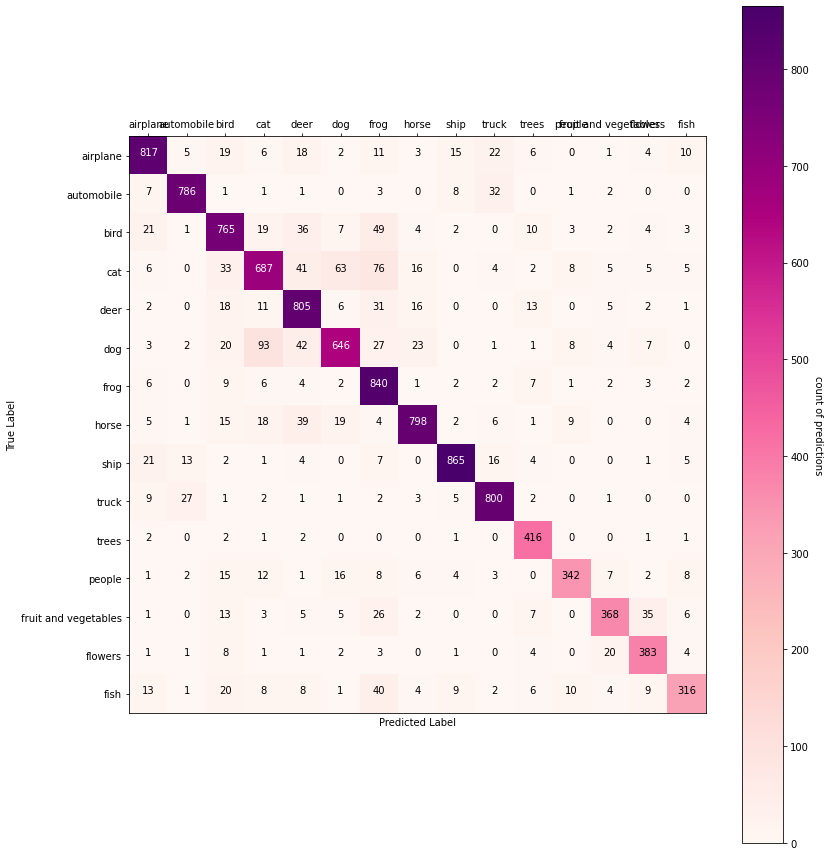

In [16]:
# labels={0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck", 10: "fish", 11: "flowers", 12: "fruit and vegetables", 13: "people", 14: "trees"}
labels={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck',
            10:'trees',11:'people',12:'fruit and vegetables',13:'flowers',14:'fish'}
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels.values(), labels.values(), ax=ax,
                   cmap=plt.cm.RdPu, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()


In [17]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       939
           1       0.94      0.93      0.94       842
           2       0.81      0.83      0.82       926
           3       0.79      0.72      0.75       951
           4       0.80      0.88      0.84       910
           5       0.84      0.74      0.78       877
           6       0.75      0.95      0.83       887
           7       0.91      0.87      0.89       921
           8       0.95      0.92      0.93       939
           9       0.90      0.94      0.92       854
          10       0.87      0.98      0.92       426
          11       0.90      0.80      0.85       427
          12       0.87      0.78      0.83       471
          13       0.84      0.89      0.87       429
          14       0.87      0.70      0.77       451

    accuracy                           0.86     11250
   macro avg       0.86      0.85      0.85     11250
weighted avg       0.86   

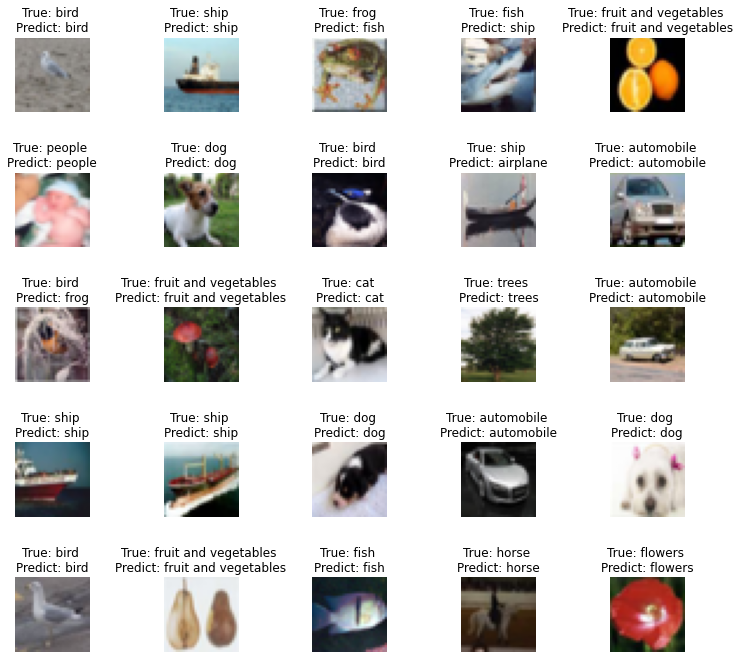

In [18]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

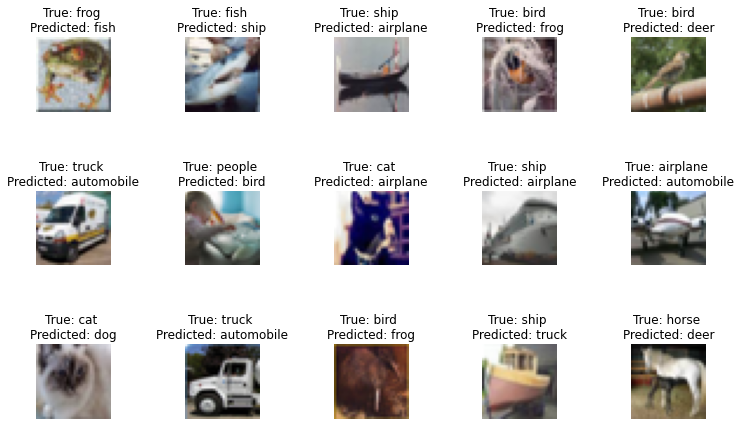

In [19]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


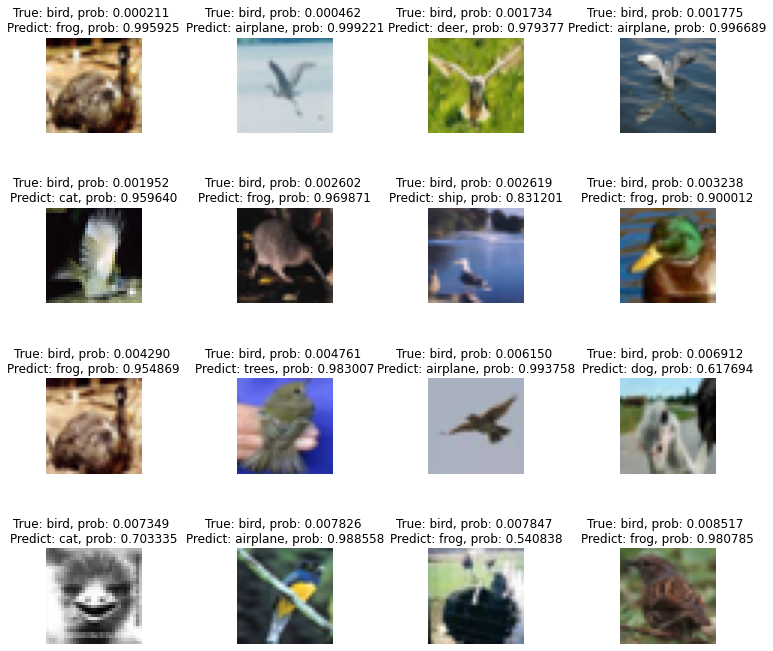

In [20]:
def worst_fails(label):
  my_label = (Y_true == label)
  label_y_pred=pred[my_label]
  label_y_pred_classes=Y_pred_classes[my_label]

  label_errors=(label_y_pred_classes!=label)
  label_y_pred_errors=label_y_pred[label_errors]
  label_y_pred_classes_errors=label_y_pred_classes[label_errors]

  label_prob = [x[label] for x in label_y_pred_errors]
  wrong_label_prob = np.max(label_y_pred_errors, axis=1) 

  label_X_test_errors =x_test[my_label]
  label_X_test_errors=label_X_test_errors[label_errors]

  labels_and_prob=pd.DataFrame()
  labels_and_prob['true_label_prob']=label_prob
  labels_and_prob['wrong_label_prob']=wrong_label_prob
  labels_and_prob['wrong_label']=label_y_pred_classes_errors
  labels_and_prob['number']=np.arange(0,len(label_prob))

    #filter all accordint to the probability

  labels_and_prob.sort_values(by=['true_label_prob'], inplace=True)

  R = 4
  C = 4
  fig, axes = plt.subplots(R, C, figsize=(12,12))
  axes = axes.ravel()

  for i in np.arange(0, R*C):
      axes[i].imshow(label_X_test_errors[int(labels_and_prob.iloc[i]['number'])])
      axes[i].set_title("True: %s, prob: %s \nPredict: %s, prob: %s" % (labels[label],format( labels_and_prob.iloc[i]['true_label_prob'] ,".6f"),labels[int(labels_and_prob.iloc[i]['wrong_label'])],format(labels_and_prob.iloc[i]['wrong_label_prob'],".6f")))

      axes[i].axis('off')
      plt.subplots_adjust(wspace=1)

worst_fails(2)

In [ ]:
#אנליזות של רחלי להוסיף כאן!!!!!!!